In [32]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

updrs_sigfall = pd.read_csv('./working_data/normalised_updrs_sigfall.csv')
updrs_sigfall_raw = pd.read_csv('./working_data/normalised_updrs_sigfall_raw.csv')
updrs_future_sigfall = pd.read_csv('./working_data/normalised_updrs_future_sigfall.csv')
updrs_future_sigfall_raw = pd.read_csv('./working_data/normalised_updrs_future_sigfall_raw.csv')
inc_updrs_sigfall = pd.read_csv('./working_data/normalised_increase_updrs_sigfall.csv')
inc_updrs_sigfall_raw = pd.read_csv('./working_data/normalised_increase_updrs_sigfall_raw.csv')
delta_updrs_sigfall = pd.read_csv('./working_data/normalised_delta_updrs_sigfall.csv')
delta_updrs_sigfall_raw = pd.read_csv('./working_data/normalised_delta_updrs_sigfall_raw.csv')

data_sources = {'updrs_sigfall': updrs_sigfall,
                'updrs_future_sigfall': updrs_future_sigfall,
                'inc_updrs_sigfall': inc_updrs_sigfall,
                'delta_updrs_sigfall': delta_updrs_sigfall}

raw_data_sources = {'updrs_sigfall_raw': updrs_sigfall_raw,
                    'updrs_future_sigfall_raw': updrs_future_sigfall_raw,
                    'inc_updrs_sigfall_raw': inc_updrs_sigfall_raw,
                    'delta_updrs_sigfall_raw': delta_updrs_sigfall_raw }

## Straight models
Running the working data directly through Linear Discriminant Analysis models
Each dataset is Cross-fold validated where k=10
Results analyzed for like for like comparison

??? Is using straight models actually Bollocks ????

In [11]:
def lda_model_score(dataset):
    try:
        X = dataset.drop(columns=['SIGFALL'])
    except:
        X = dataset.drop(columns=['SIGFALL_NEXT'])
        
    try:    
        y = dataset['SIGFALL']
    except:
        y = dataset['SIGFALL_NEXT']

    model = LinearDiscriminantAnalysis()
    scores = cross_val_score(model, X, y, cv=10)
    return scores.mean()


In [173]:
for k,v in data_sources.items():    
    s = lda_model_score(v)
    print(f'{k} score of {s}')

updrs_sigfall score of 0.9022084195997238
updrs_future_sigfall score of 0.8999999999999998
inc_updrs_sigfall score of 0.9101908657123381
delta_updrs_sigfall score of 0.9118516769012753


In [162]:
for k,v in raw_data_sources.items():    
    s = lda_model_score(v)
    print(f'{k} score of {s}')

updrs_sigfall_raw score of 0.9022084195997238
updrs_future_sigfall_raw score of 0.8999999999999998
inc_updrs_sigfall_raw score of 0.9120275694917821
delta_updrs_sigfall_raw score of 0.9118516769012753


## Using confusion matricies to understand errors
Inbalances in data lead to bias in model
eg if in doubt call it 0

investigate the models again, this time analyzing for ????

In [115]:
def lda_confusion_matrix(dataset):
        X_train, X_test, y_train, y_test = train_test_split(dataset.iloc[:, :-1], dataset.iloc[:, -1], test_size=0.25)
        lda_model = LinearDiscriminantAnalysis()
        predictions = lda_model.fit(X_train, y_train).predict(X_test)
        tn, fn, fp, tp = confusion_matrix(predictions, y_test.values).ravel()
        return {'true_negative': tn, 'false_negative': fn, 'false_positive': fp, 'true_positive': tp}


def analyse_confusion_matrix(cm):
    tn, fp, fn, tp = cm
    sensitivity = tp / (tp + fn)
    specificity = fp / fp + tn
    precision = tp / (tp + fp)
    return (sensitivity,precision)

def sensitivity(cm):
    return cm['true_positive'] / (cm['true_positive'] + cm['false_negative'])

def specificity(cm):
    return cm['true_negative'] / ( cm['true_negative'] + cm['false_positive'] )

def false_positive_rate(cm):
    return (1.0 - (specificity(cm)) )

In [114]:
# for k,v in raw_data_sources.items():
#     print(f'--- {k} ---')
#     totals = []
#     nfs = []
#     falls = []
#     for n in range(10):
#         m = lda_confusion_matrix(v)
#         t, nf, f = analyse_confusion_matrix(m)
#         totals.append(t)
#         nfs.append(nf)
#         falls.append(f)
#     avg_total = np.array(totals).mean()
#     avg_nfs = np.array(nfs).mean()
#     avg_falls = np.array(falls).mean()
#     print(f'Total {avg_total}\nNo fall {avg_nfs}\nFalls {avg_falls}\n')
    
# # to do - stick this in a df
x = lda_confusion_matrix(updrs_future_sigfall)
print(specificity(x))
sensitivity(x)

0.9969604863221885


0.027777777777777776

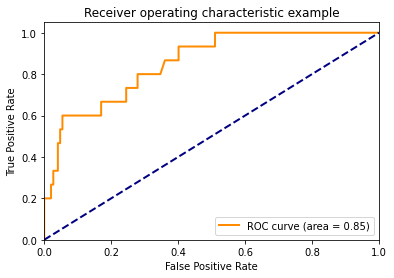

In [60]:
#ROCing out
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(updrs_sigfall.iloc[:, :-1], updrs_sigfall.iloc[:, -1], test_size=0.1)
lda_model = LinearDiscriminantAnalysis()
y_score = lda_model.fit(X_train, y_train).decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc = auc(fpr,tpr)

# plotting stuff example
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [63]:
# So AUC score is a good way of analyzing our models 
# Lets run a bunch to generate a collection of AUC scores and use that to analyze accuracy of models
roc_auc_score(y_test.ravel(), y_score.ravel())

0.853968253968254

## Balanced data set approach
What happens if we balance out the sigfall ratios and recreate our models?
Can we beat random ?

In [9]:
# Get 
sigfall_indexes = updrs_sigfall.index[updrs_sigfall['SIGFALL'] == 0].to_list()
n_falls = len(updrs_sigfall) - len(sigfall_indexes)
drop = len(sigfall_indexes) - n_falls
random.shuffle(sigfall_indexes)
drop_indexes = sigfall_indexes[0:drop]


In [10]:
balanced_updrs_sigfall = updrs_sigfall.drop(drop_indexes)
check1 = balanced_updrs_sigfall.index[balanced_updrs_sigfall['SIGFALL'] == 0].to_list()
check2 = balanced_updrs_sigfall.index[balanced_updrs_sigfall['SIGFALL'] == 1].to_list()

print(len(check1))
print(len(check2))
balanced_updrs_sigfall.head()

130
130


,NP2SPCH,NP2SALV,NP2SWAL,NP2EAT,NP2DRES,NP2HYGN,NP2HWRT,NP2HOBB,NP2TURN,NP2TRMR,NP2RISE,NP2WALK,NP2FREZ,NP2PTOT,SIGFALL
2,0.00,0.00,0.00,0.25,0.50,0.25,0.50,0.5,0.25,0.50,0.50,0.00,0.00,0.250000,0.0
3,0.25,0.00,0.25,0.25,0.50,0.25,0.50,0.5,0.25,0.50,0.50,0.25,0.00,0.307692,1.0
4,0.50,0.75,0.25,0.50,0.50,0.25,0.75,0.5,0.50,0.25,0.50,0.75,0.00,0.461538,0.0
17,0.00,0.75,0.25,0.25,0.25,0.25,0.25,0.5,0.50,0.25,0.25,0.75,0.75,0.384615,1.0
18,0.75,1.00,0.75,0.00,0.50,0.50,0.25,0.0,0.00,0.25,1.00,1.00,0.00,0.461538,1.0


In [13]:
lda_model_score(balanced_updrs_sigfall)

0.6423076923076924

In [22]:
analyse_confusion_matrix(lda_confusion_matrix(balanced_updrs_sigfall))

(0.6153846153846154, 0.8333333333333334, 0.42857142857142855)